In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample_GPC, refine_sample2, draw_density_ratio2, draw_density_ratio_GPC, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

# GP Classifier Sim+ vs Real+

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP, draw_density_ratio_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)
import math


sim2real!!!


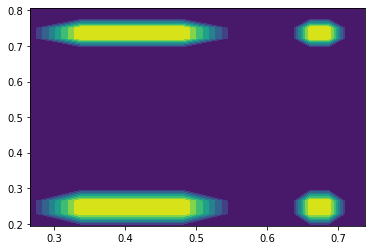

In [134]:
# USING 2D FORK DATA ===============================
n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=500, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
# train_y = torch.Tensor(train_dataset.data[:,2]).long()
train_y = torch.Tensor(train_dataset.data[:,2]).long() * 2 -1 

train_x[:,0] /= 244
train_x[:,1] /= 2*(3.14)

# y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_x[:,0] /= 244
test_x[:,1] /= 2*(3.14)

# test_y = torch.Tensor(test_dataset.data[:,2]).long()
test_y = torch.Tensor(test_dataset.data[:,2]).long() * 2 -1 
test_labels = torch.reshape(test_y, (n, n))


plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [135]:
# print(train_y[train_y==1].sum())
# # print(train_y.shape[0])
# train_x = torch.linspace(0, 1, 100)
# train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))

In [136]:
import gpytorch
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import UnwhitenedVariationalStrategy

class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
#         variational_strategy = VariationalStrategy(
#             self, train_x, variational_distribution)
        
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=True
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
#         self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [137]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500




# Find optimal model hyperparameters

model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

from gpytorch.mlls.variational_elbo import VariationalELBO
# "Loss" for GPs - the marginal log likelihood
mll = VariationalELBO(likelihood, model, train_y.numel())


# model, likelihood, train_x, train_y = model.to(device), likelihood.to(device), train_x.to(device), train_y.to(device)
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/500 - Loss: 0.909
Iter 51/500 - Loss: 2.951
Iter 101/500 - Loss: 2.357
Iter 151/500 - Loss: 1.663
Iter 201/500 - Loss: 1.286
Iter 251/500 - Loss: 1.021
Iter 301/500 - Loss: 0.771
Iter 351/500 - Loss: 0.625
Iter 401/500 - Loss: 0.534
Iter 451/500 - Loss: 0.528


In [138]:
pos_masks = train_y == 1
neg_masks = ~pos_masks
# pos_masks, neg_masks = pos_masks.cpu(), neg_masks.cpu()

# train_x = train_x.cpu().numpy()


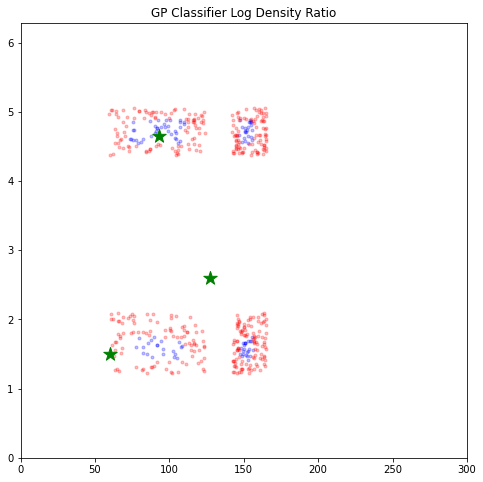

tensor([0.1016, 0.7063, 0.4539], grad_fn=<MulBackward0>)
tensor([0.1016, 0.7063, 0.4539], grad_fn=<MulBackward0>)


In [141]:
import torch
torch.cuda.empty_cache()

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [93, 4.65],
                               [127, 2.6]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)



fig, ax = plt.subplots(nrows=1, figsize=(8,8))
ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.25, color='b')
ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.25, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)

# Z, CS = draw_density_ratio_GPC(ax=ax,
#                    model=model,
#                    likelihood=likelihood,
# #                    model=model.to(device),
# #                    likelihood=likelihood.to(device),
# #                    p_type='p_y_given_x',
#                    p_type='log_density_ratio',
#                    device=device,
#                    x_lim=[0, 224],
#                    y_lim=[0, 2*np.pi],
#                    cmap='RdBu',
#                    step_size=0.1,
#                    Np=Np, Nq=Nq)
# fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()
print(likelihood(model(my_sample)).probs)
model.eval()
likelihood.eval()
print(likelihood(model(my_sample)).probs)


Text(0.5, 1.0, 'Predictions: ')

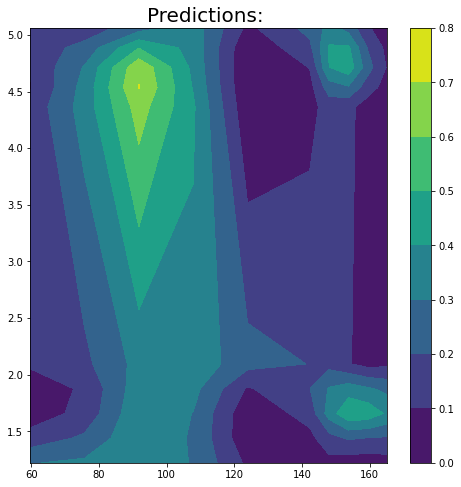

In [140]:
model.eval()
likelihood.eval()
model = model.to('cpu')

# t_x = test_x.clone().to(device)
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = likelihood(model(test_x))
#     test_dist = _test_dist.clone().cpu()
    _pred_means = test_dist.mean
    pred_means = _pred_means.clone().cpu()
    
    
fig, ax = plt.subplots(nrows=1, figsize=(8,8))

ax.contourf(test_x_mat.numpy()*224, test_y_mat.numpy()*(2*3.14), pred_means.numpy().reshape((n,n)))
fig.colorbar(im, ax=ax)
ax.set_title("Predictions: " , fontsize = 20)